Comparamos varios modelos que hemos seleccionado con el notebook de entrenamiento usando los siguientes procesos:

1. ROC crurve 

    1.1 kde de la probabilidad
    
    1.2 KS-test
    
2. Feature importance y SHAP
3. Performance para buenos clientes
4. Performance con el dataset de barrido diario para el mejor de estos
5. para el que se escoje tambén toca hacer el entrenamiento del autoencoder de con datasets de entrenamiento aleatorio
6. ver cuales son los errores con los malos que pone como buenos para validar que tan grave es


In [1]:
import numpy as np
import pandas as pd

import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
import shap
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, \
                            auc, plot_precision_recall_curve
from scipy.stats import ks_2samp


# Load dataset and models

these datasets have been transformed by an autoencoder already to accound for the difference between including selected account and not including selected account when building the autoencoder time series

In [3]:
# load transformed datasets for each mode.
# 15 latent variables and using selected account filter for the autoencoder tensor
train_set_z15_selected = pd.read_csv('autoencoder_models_selected_acc_filter/train_set_15_new_selected_acc.csv', index_col = 'loan_id')
test_set_z15_selected = pd.read_csv('autoencoder_models_selected_acc_filter/test_set_15_new_selected_acc.csv',index_col = 'loan_id')

# 20 latent variables and without selected account filter for the autoencoder tensor

train_set_z20_notselected = pd.read_csv(
            'autoencoder_models_without_selected_acc_filter/train_set_20_new_selected_acc.csv', index_col = 'loan_id')
test_set_z20_notselected = pd.read_csv(
                'autoencoder_models_without_selected_acc_filter/test_set_20_new_no_selected_acc.csv', index_col = 'loan_id')


In [4]:
# load pre trained classification models
xgb_15_selected = joblib.load('autoencoder_models_selected_acc_filter/xgboost_z15_new_selected_acc.p')

xgb_20_notselected = joblib.load('autoencoder_models_without_selected_acc_filter/xgboost_z20_new_no_selected_acc.p')

In [5]:
# save labels
label_col = 'loan_status'
label_encoded ='status_encoded'

# save feature names
z15_features = test_set_z15_selected.drop(label_col, axis=1).columns
z20_features = test_set_z20_notselected.drop(label_col, axis=1).columns

In [47]:
z20_features


Index(['fixcost_days', 'cashin_days', 'cashin_count', 'fixcost_count',
       'recent_cashin_count', 'r1', 'r2', 'r3', 'frequency', 'r4',
       'cashin_1_month', 'cashin_2_month', 'cashin_3_month', 'fixcost_1_month',
       'fixcost_2_month', 'fixcost_3_month', 'negative_count_month_0',
       'negative_count_month_1', 'negative_count_month_2',
       'positive_count_month_0', 'positive_count_month_1',
       'positive_count_month_2', 'count_std', 'count_mean', 'sum_std',
       'sum_mean', 'last_2_weeks_positive_count', 'last_2_weeks_positive_sum',
       'last_2_weeks_negative_count', 'last_2_weeks_negative_sum',
       'days_since_last_txs', 'Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5', 'Dim6',
       'Dim7', 'Dim8', 'Dim9', 'Dim10', 'Dim11', 'Dim12', 'Dim13', 'Dim14',
       'Dim15'],
      dtype='object')

In [6]:
# create the predictions for z=15 model that was trained with the selected filter

train_set_z15_selected['predicted_proba'] =\
                    xgb_15_selected.predict_proba(train_set_z15_selected[z15_features])[:,1]

train_set_z15_selected['predicted_label'] =\
                    xgb_15_selected.predict(train_set_z15_selected[z15_features])

# test
test_set_z15_selected['predicted_proba'] =\
                    xgb_15_selected.predict_proba(test_set_z15_selected[z15_features])[:,1]

test_set_z15_selected['predicted_label'] =\
                    xgb_15_selected.predict(test_set_z15_selected[z15_features])


In [7]:
# create the predictions for z=20 model that was trained without the selected filter
train_set_z20_notselected['predicted_proba'] =\
                    xgb_20_notselected.predict_proba(train_set_z20_notselected[z20_features])[:,1]

train_set_z20_notselected['predicted_label'] =\
                    xgb_20_notselected.predict(train_set_z20_notselected[z20_features])

# test
test_set_z20_notselected['predicted_proba'] =\
                    xgb_20_notselected.predict_proba(test_set_z20_notselected[z20_features])[:,1]

test_set_z20_notselected['predicted_label'] =\
                    xgb_20_notselected.predict(test_set_z20_notselected[z20_features])


In [8]:
print(train_set_z15_selected[label_col].value_counts())
print(test_set_z15_selected[label_col].value_counts())


8    801
2    134
Name: loan_status, dtype: int64
8    319
2     95
Name: loan_status, dtype: int64


In [9]:
# encode the label
train_set_z15_selected[label_encoded] = 0
train_set_z15_selected.loc[train_set_z15_selected[label_col]==8, label_encoded] = 1

test_set_z15_selected[label_encoded] = 0
test_set_z15_selected.loc[test_set_z15_selected[label_col]==8, label_encoded] = 1

print(train_set_z15_selected[label_encoded].value_counts())
print(test_set_z15_selected[label_encoded].value_counts())


1    801
0    134
Name: status_encoded, dtype: int64
1    319
0     95
Name: status_encoded, dtype: int64


In [10]:
# encode the label
train_set_z20_notselected[label_encoded] = 0
train_set_z20_notselected.loc[train_set_z20_notselected[label_col]==8, label_encoded] = 1

test_set_z20_notselected[label_encoded] = 0
test_set_z20_notselected.loc[test_set_z20_notselected[label_col]==8, label_encoded] = 1

print(train_set_z15_selected[label_encoded].value_counts())
print(test_set_z20_notselected[label_encoded].value_counts())

1    801
0    134
Name: status_encoded, dtype: int64
1    319
0     95
Name: status_encoded, dtype: int64


# Classification metrics comparisson

### Confusion matrix and classification report

In [11]:
print('z = 15 model')
print('training')
print( classification_report(train_set_z15_selected[label_col], train_set_z15_selected['predicted_label']) )
print( confusion_matrix(train_set_z15_selected[label_col], train_set_z15_selected['predicted_label']) )

print('test')
print( classification_report(test_set_z15_selected[label_col], test_set_z15_selected['predicted_label']) )
print( confusion_matrix(test_set_z15_selected[label_col], test_set_z15_selected['predicted_label']) )


z = 15 model
training
              precision    recall  f1-score   support

           2       1.00      0.69      0.82       134
           8       0.95      1.00      0.98       801

    accuracy                           0.96       935
   macro avg       0.98      0.85      0.90       935
weighted avg       0.96      0.96      0.95       935

[[ 93  41]
 [  0 801]]
test
              precision    recall  f1-score   support

           2       0.60      0.13      0.21        95
           8       0.79      0.97      0.87       319

    accuracy                           0.78       414
   macro avg       0.69      0.55      0.54       414
weighted avg       0.75      0.78      0.72       414

[[ 12  83]
 [  8 311]]


In [12]:
print('z = 20 model without selected')
print('training')
print( classification_report(train_set_z20_notselected[label_col], train_set_z20_notselected['predicted_label']) )
print( confusion_matrix(train_set_z20_notselected[label_col], train_set_z20_notselected['predicted_label']) )

print('test')
print( classification_report(test_set_z20_notselected[label_col], test_set_z20_notselected['predicted_label']) )
print( confusion_matrix(test_set_z20_notselected[label_col], test_set_z20_notselected['predicted_label']) )


z = 20 model without selected
training
              precision    recall  f1-score   support

           2       0.43      0.32      0.37       134
           8       0.89      0.93      0.91       801

    accuracy                           0.84       935
   macro avg       0.66      0.63      0.64       935
weighted avg       0.83      0.84      0.83       935

[[ 43  91]
 [ 56 745]]
test
              precision    recall  f1-score   support

           2       0.30      0.19      0.23        95
           8       0.78      0.87      0.82       319

    accuracy                           0.71       414
   macro avg       0.54      0.53      0.53       414
weighted avg       0.67      0.71      0.69       414

[[ 18  77]
 [ 43 276]]


### ROC curve and precision recall


In [13]:
def plot_roc_curve(y_train_true, y_train_probas, y_test_true, y_test_probas):
    # y_true: series with the true labels encoded in 0 and 1
    # y_probas: probability estimates by the model
    
    # train roc calculattion
    fpr_train, tpr_train, _ = roc_curve(y_train_true, y_train_probas)
    auc_train = roc_auc_score(y_train_true, y_train_probas)
    auc_train = auc_train.round(3)

    # test roc calculattion
    fpr_test, tpr_test, _ = roc_curve(y_test_true, y_test_probas)
    auc_test = roc_auc_score(y_test_true, y_test_probas)
    auc_test = auc_test.round(3)
    
    plt.figure(figsize=(8,7))
    plt.title('roc_curve')
    #plot train
    plt.plot(fpr_train, tpr_train, label='train_auc={}'.format(auc_train), color='orangered')
    
    # plot test
    plt.plot(fpr_test, tpr_test, label='test_auc={}'.format(auc_test), color='mediumorchid')
    # plot baseline
    plt.plot([0, 1], [0, 1], 'k--')
    
    # format axis
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    

ROC z=15


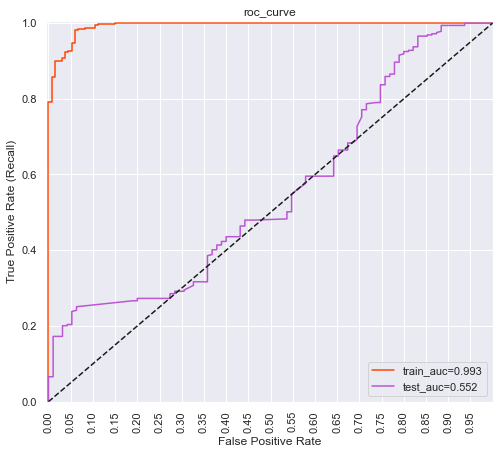

In [14]:
print('ROC z=15')    
plot_roc_curve(train_set_z15_selected[label_encoded], train_set_z15_selected['predicted_proba'],
               test_set_z15_selected[label_encoded], test_set_z15_selected['predicted_proba'])

ROC z=20


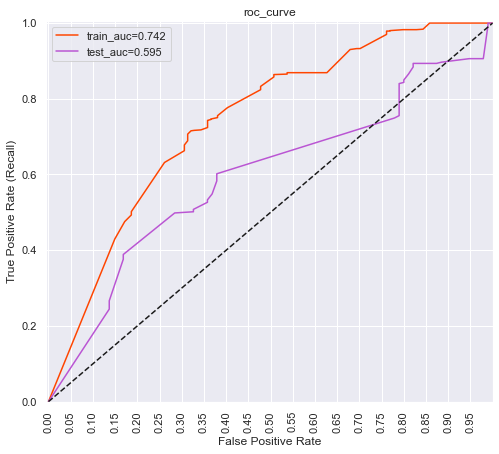

In [15]:
print('ROC z=20')    
plot_roc_curve(train_set_z20_notselected[label_encoded], train_set_z20_notselected['predicted_proba'],
               test_set_z20_notselected[label_encoded], test_set_z20_notselected['predicted_proba'])

### KDE  probability between good and bad clients

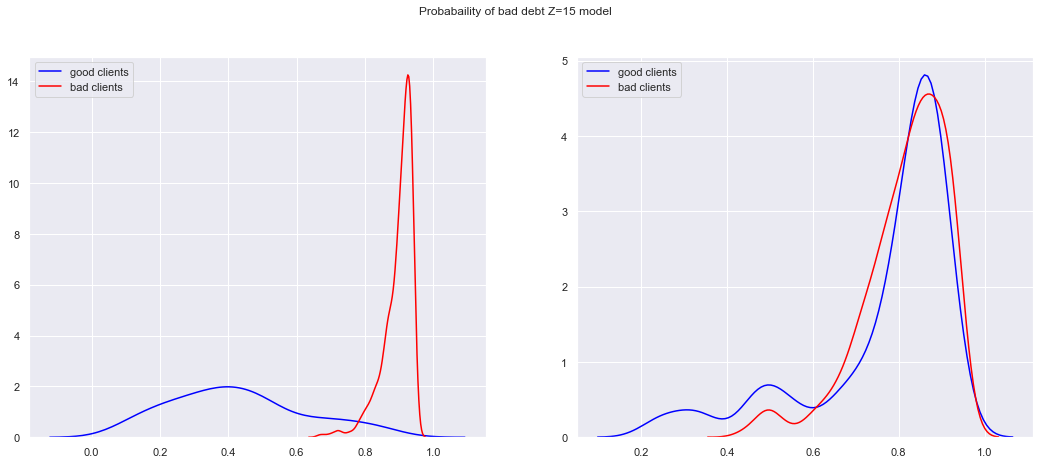

In [16]:
df_train = train_set_z15_selected
df_test = test_set_z15_selected
plt.figure(figsize=(18,7))
plt.suptitle('Probabaility of bad debt Z=15 model')
plt.subplot(1,2,1)
sns.kdeplot(df_train[df_train['loan_status']==2]['predicted_proba'], color='blue', label='good clients')
sns.kdeplot(df_train[df_train['loan_status']==8]['predicted_proba'], color='red',label='bad clients')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(df_test[df_test['loan_status']==2]['predicted_proba'], color='blue', label='good clients')
sns.kdeplot(df_test[df_test['loan_status']==8]['predicted_proba'],color='red',label='bad clients')

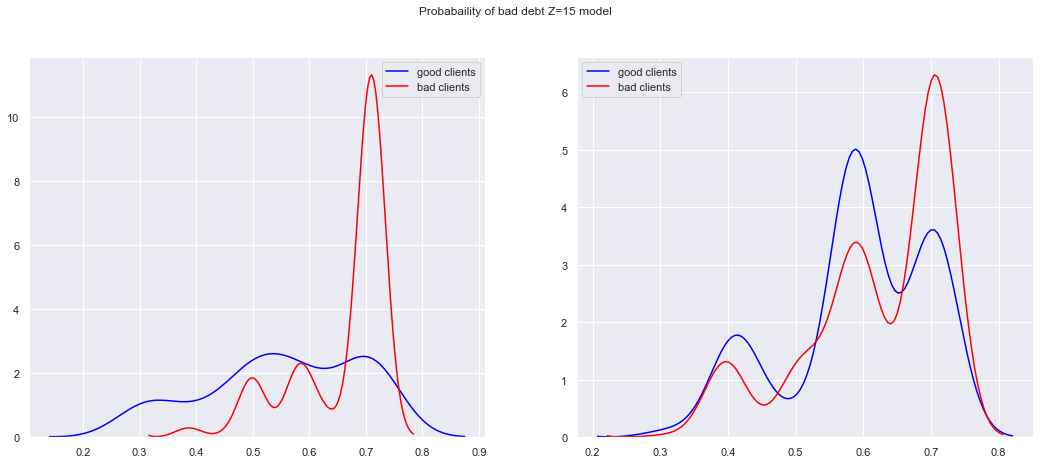

In [17]:
df_train = train_set_z20_notselected
df_test = test_set_z20_notselected
plt.figure(figsize=(18,7))
plt.suptitle('Probabaility of bad debt Z=15 model')
plt.subplot(1,2,1)
sns.kdeplot(df_train[df_train['loan_status']==2]['predicted_proba'], color='blue', label='good clients')
sns.kdeplot(df_train[df_train['loan_status']==8]['predicted_proba'], color='red',label='bad clients')
plt.legend()

plt.subplot(1,2,2)
sns.kdeplot(df_test[df_test['loan_status']==2]['predicted_proba'], color='blue', label='good clients')
sns.kdeplot(df_test[df_test['loan_status']==8]['predicted_proba'],color='red',label='bad clients')

### Kolmogorov-smirnov for goodness of fit

In [18]:
print('for z = 20 and without selected acc filter')
ks_2samp(test_set_z20_notselected[test_set_z20_notselected['loan_status']==2]['predicted_proba'],
         test_set_z20_notselected[test_set_z20_notselected['loan_status']==8]['predicted_proba'])


for z = 20 and without selected acc filter


Ks_2sampResult(statistic=0.22293350932189407, pvalue=0.001110729776533259)

In [19]:
print('for z = 15 and with selected acc filter')
ks_2samp(test_set_z15_selected[test_set_z15_selected['loan_status']==2]['predicted_proba'],
         test_set_z15_selected[test_set_z15_selected['loan_status']==8]['predicted_proba'])


for z = 15 and with selected acc filter


Ks_2sampResult(statistic=0.18762580432271903, pvalue=0.00974826721132771)

# Performance in time

recordemos mirar los good clients.

Para esto encesitamos cargar los autoencoders y hacer resto de preddiciones antes de xgboost


# MODEL Z=20

In [59]:
predictions_in_time_model1 = pd.read_csv('predictions_in_time_z20.csv')
predictions_in_time_model1 = predictions_in_time_model1.sort_values('prediction')

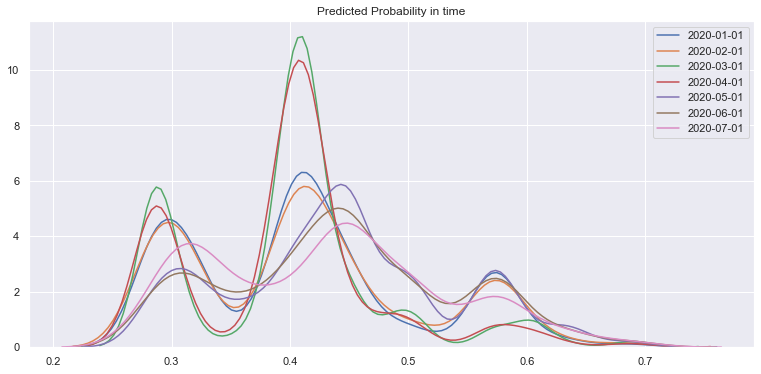

In [63]:
c_date = ['2020-01-01','2020-02-01','2020-03-01','2020-04-01','2020-05-01','2020-06-01','2020-07-01']

plt.figure(figsize=(13,6))
plt.title('Predicted Probability in time')
for cd in c_date:
    current_data = predictions_in_time_model1[predictions_in_time_model1['prediction']==cd]
    sns.kdeplot(current_data['proba_of_being_good'], label=cd)
plt.legend()


(0.0, 1.0)

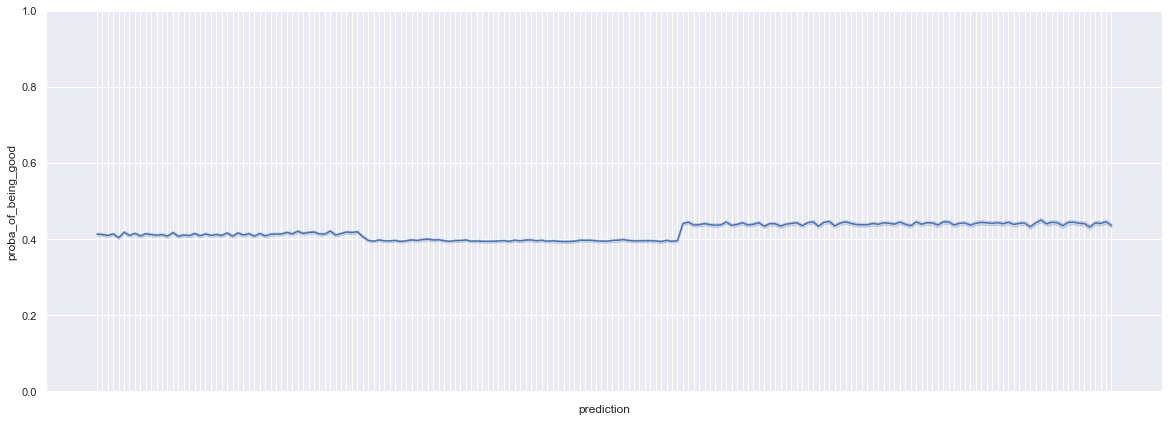

In [83]:
plt.figure(figsize=(20,7))
bplot = sns.lineplot(x='prediction', y = 'proba_of_being_good', data=predictions_in_time_model1);
bplot.set_xticklabels(bplot.get_xticklabels(),rotation=70);
plt.ylim(0,1)

## Para los clientes buenos

In [67]:
good_client_ids = [  15,   17,   22,   84,   94,  106,  200,  264,  512, 1107, 1189,
       1216, 1270, 1287, 1808, 1999, 2052, 2195, 3054, 3055, 3453, 3496,
       4950, 5070, 5426]


In [71]:
good_predictions = predictions_in_time_model1[predictions_in_time_model1['customer_id'].isin(good_client_ids)].copy()
good_predictions.customer_id.nunique()

22

(0.0, 1.0)

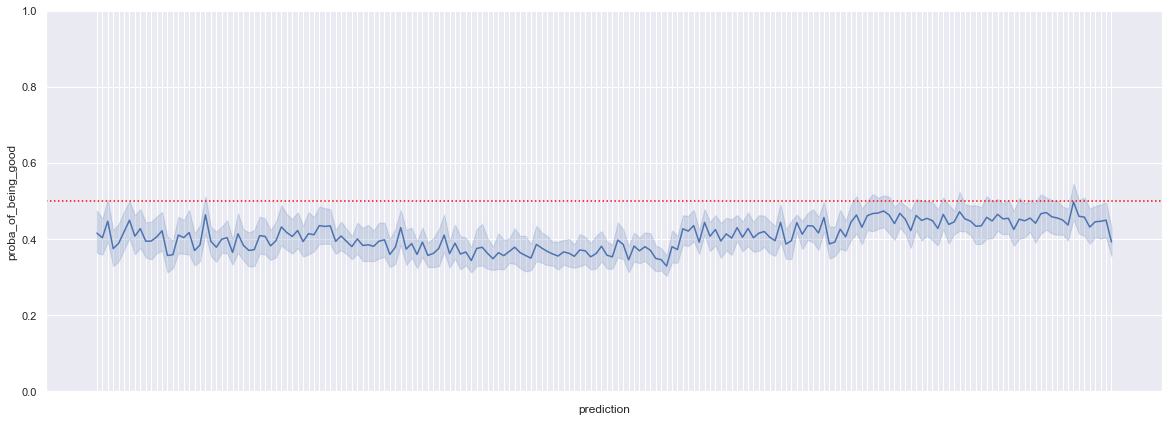

In [87]:
plt.figure(figsize=(20,7))
bplot = sns.lineplot(x='prediction', y = 'proba_of_being_good', data=good_predictions);
bplot.axhline(0.5, color='red', linestyle=':')

bplot.set_xticklabels(bplot.get_xticklabels(),rotation=70);
plt.ylim(0,1)

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open

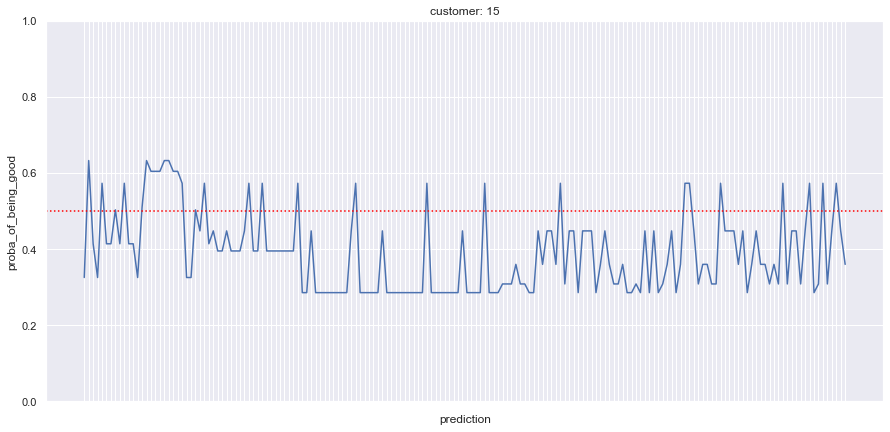

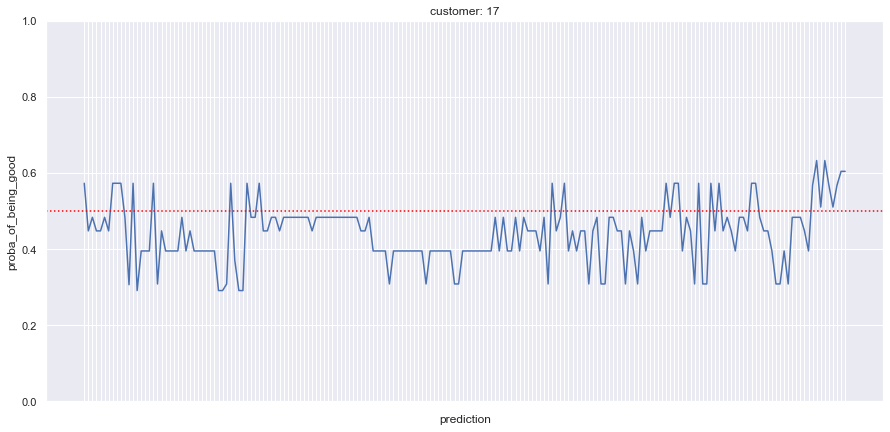

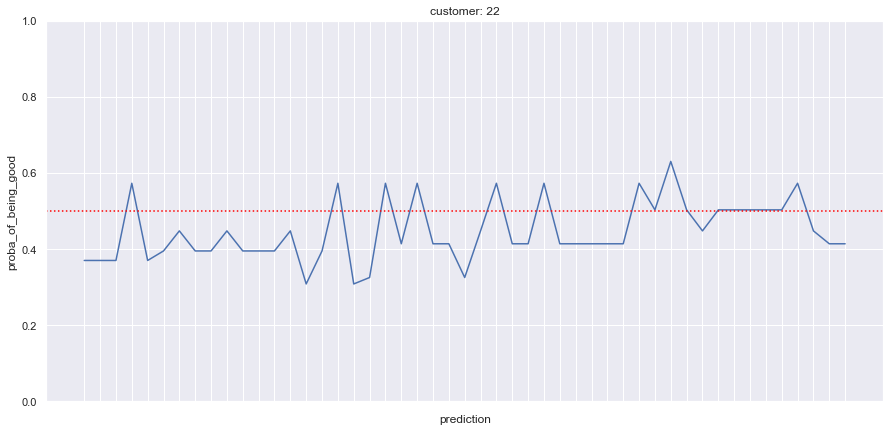

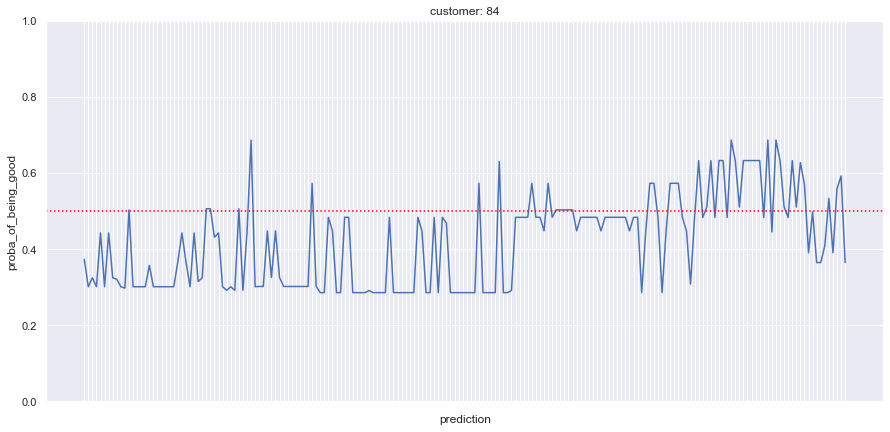

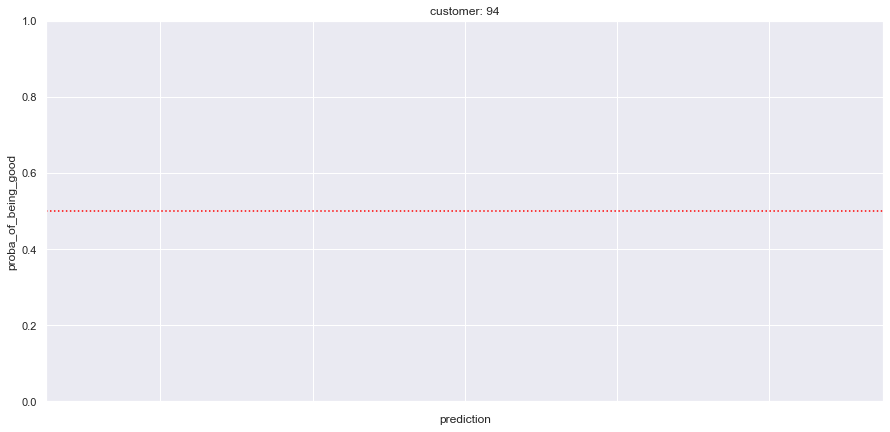

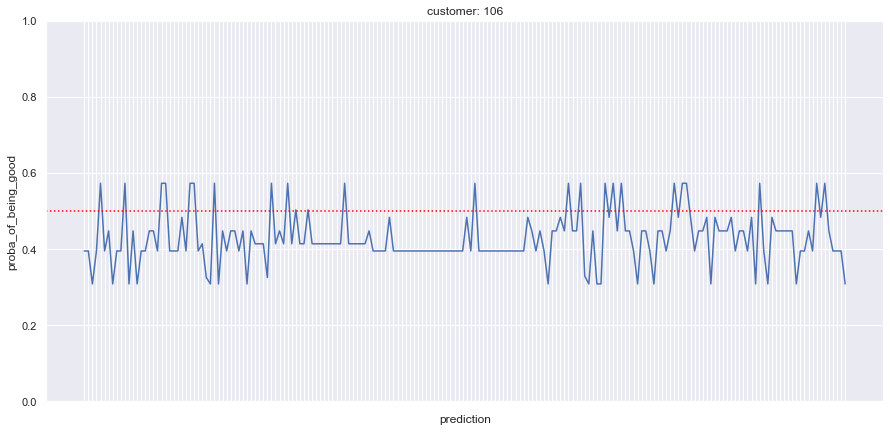

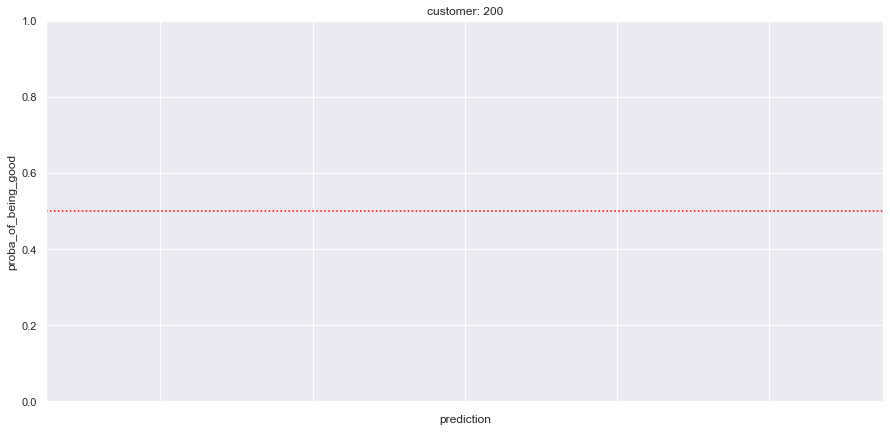

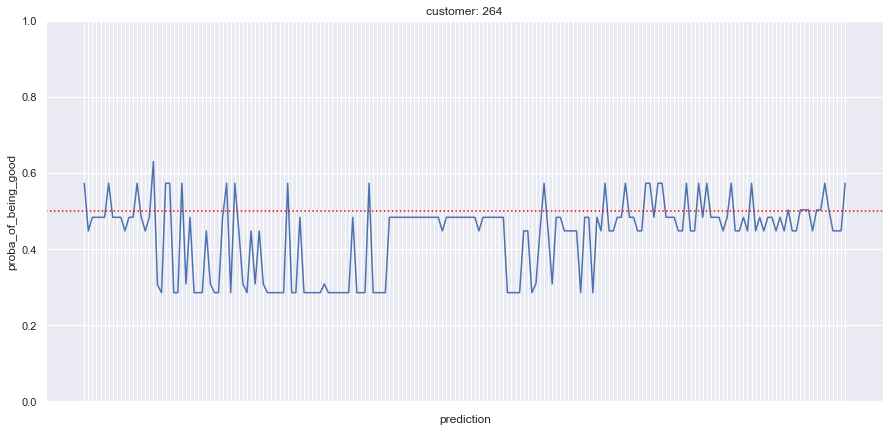

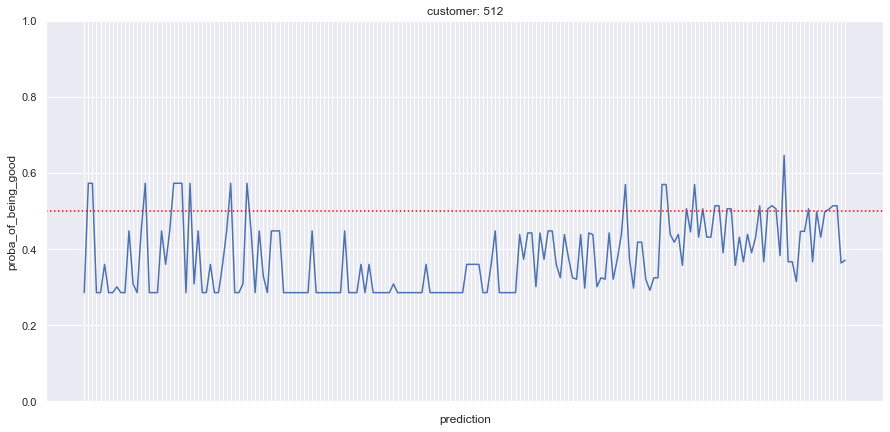

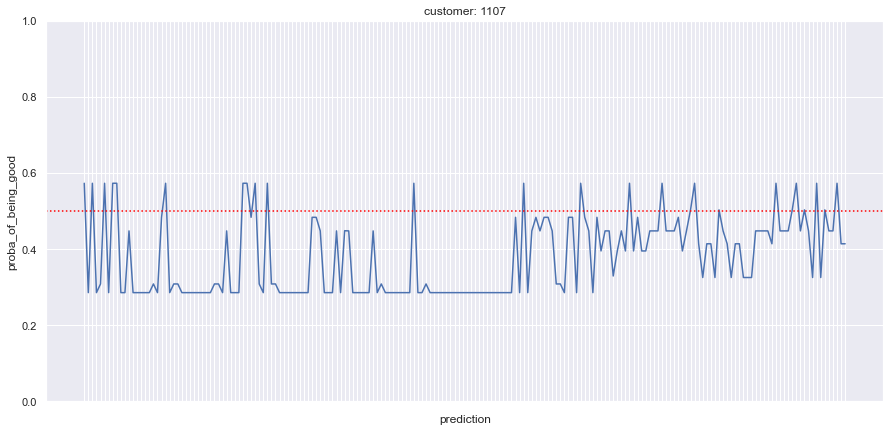

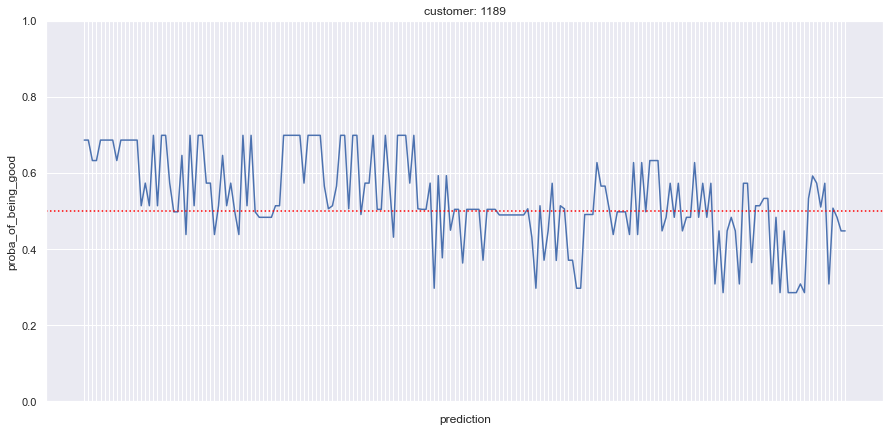

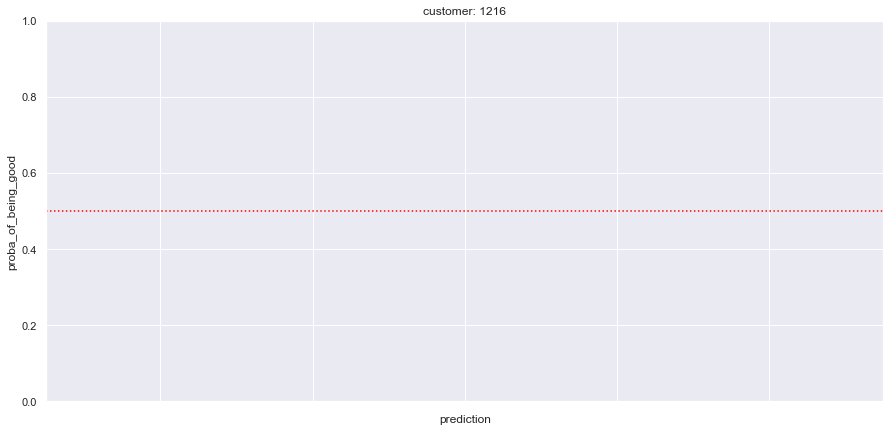

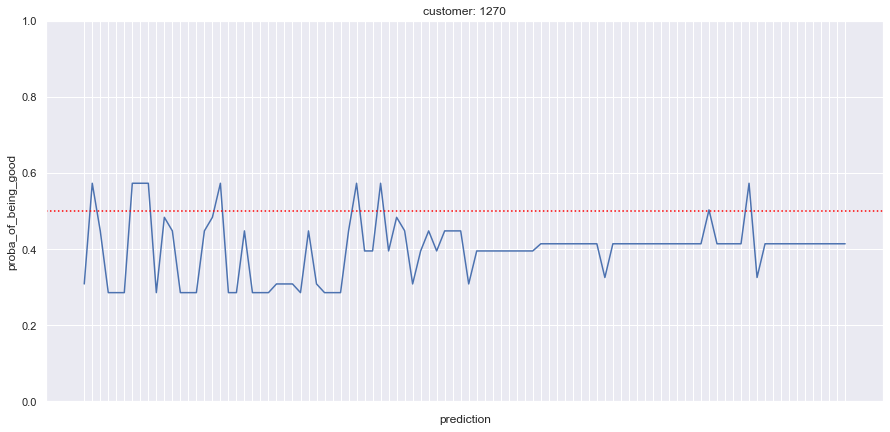

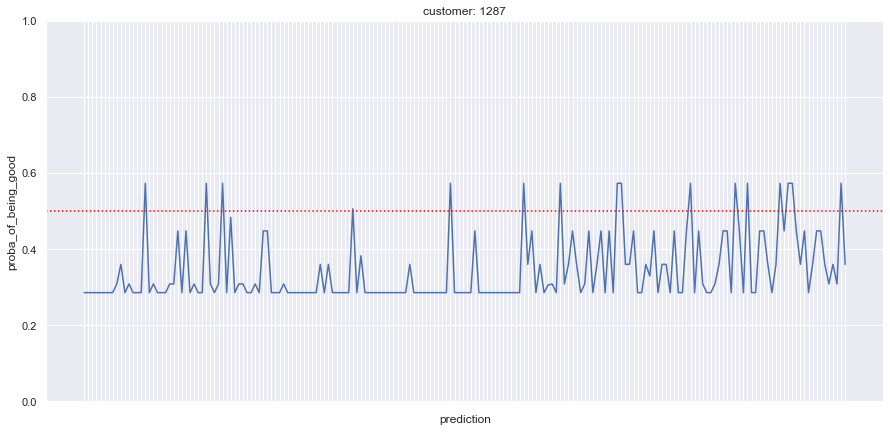

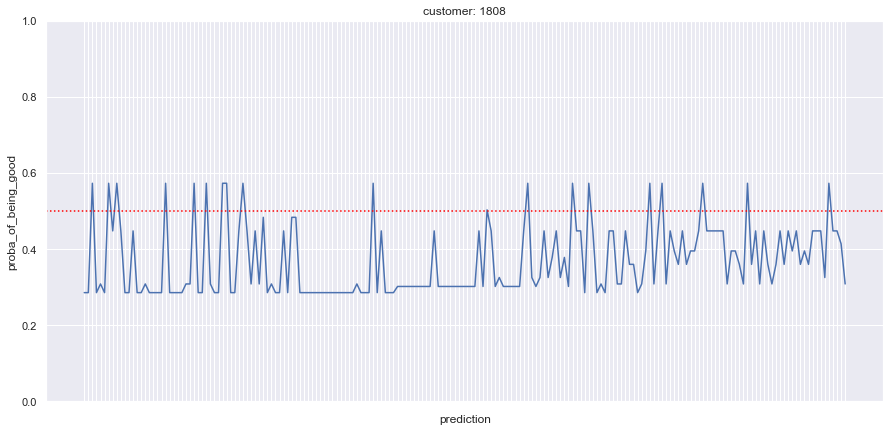

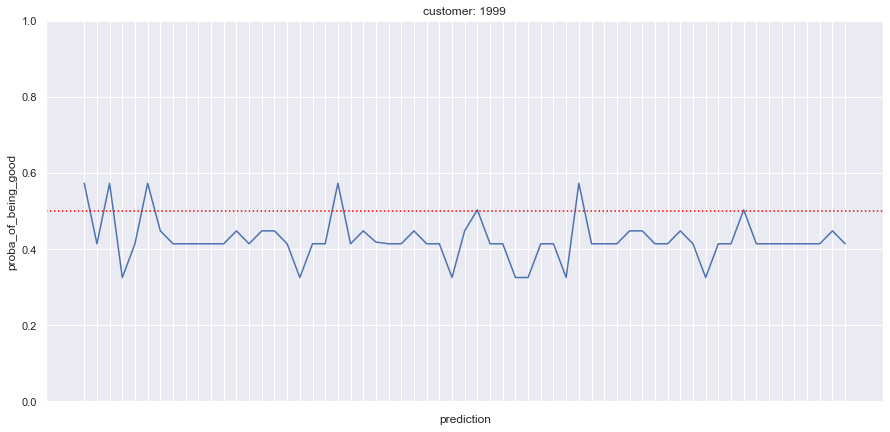

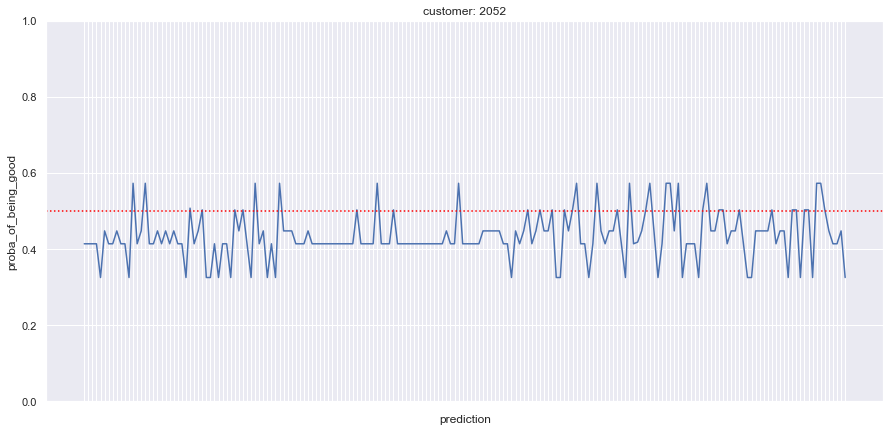

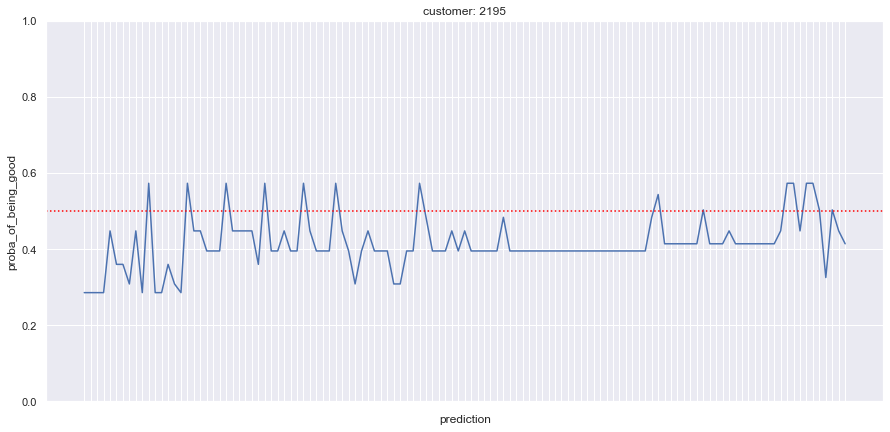

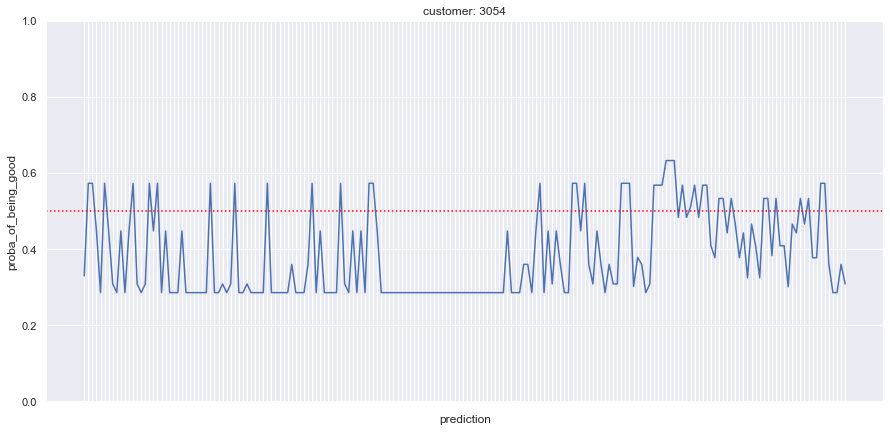

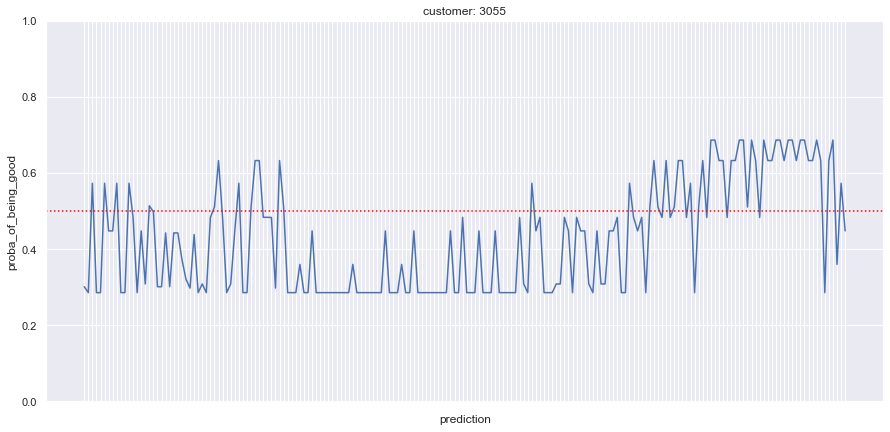

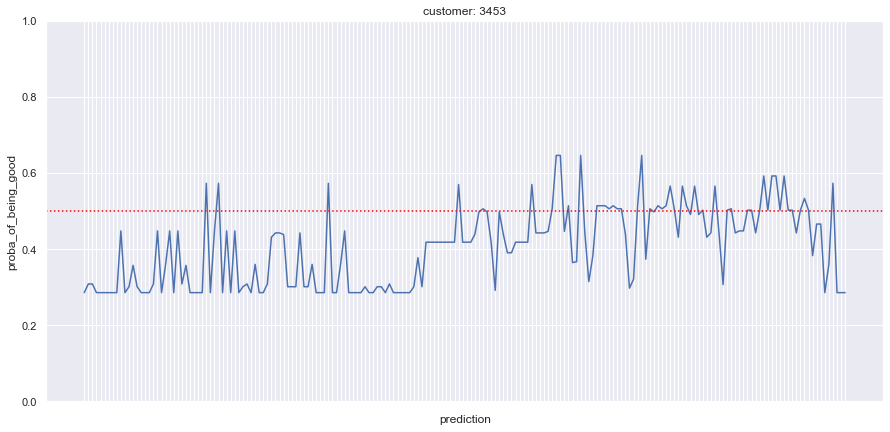

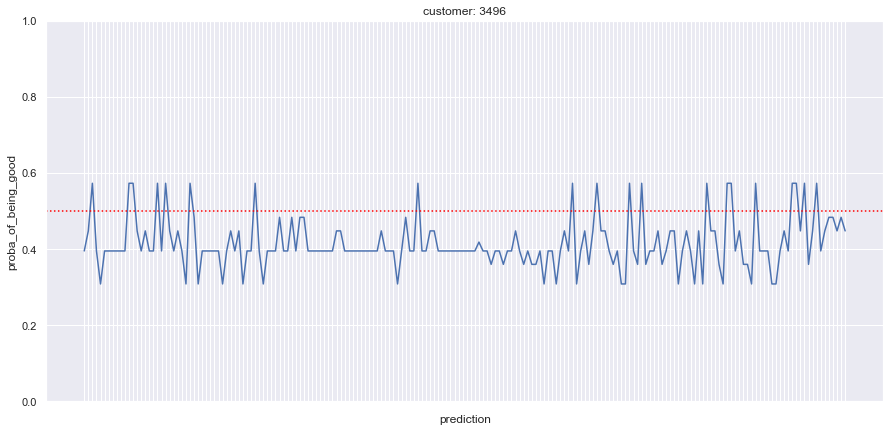

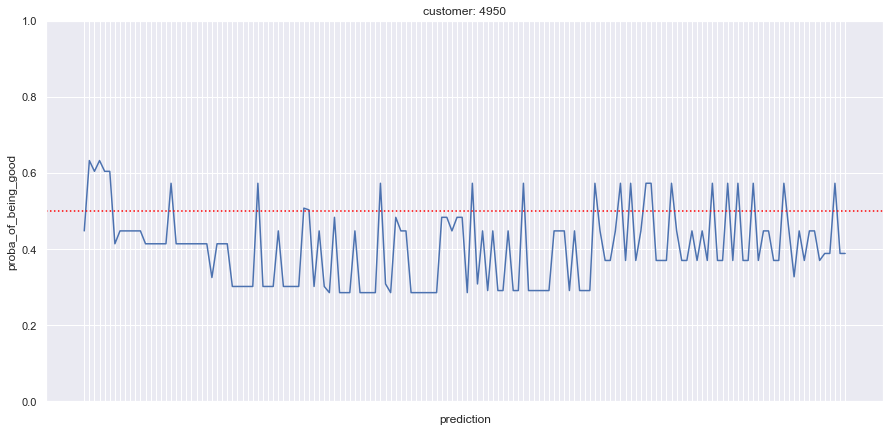

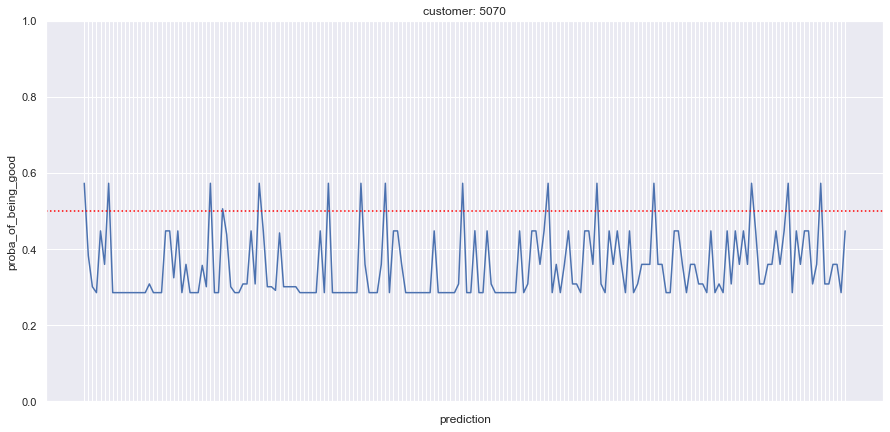

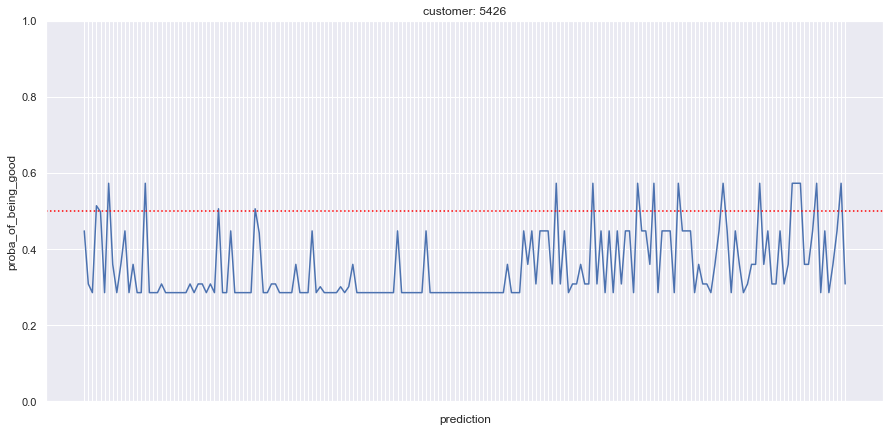

In [88]:

for c in good_client_ids:
    curr_df = good_predictions[good_predictions.customer_id == c ]
    plt.figure(figsize=(15,7))
    plt.title('customer: {}'.format(c))
    bplot = sns.lineplot(x='prediction', y = 'proba_of_being_good',data=curr_df);
    bplot.axhline(0.5, color='red', linestyle=':')
    bplot.set_xticklabels(bplot.get_xticklabels(),rotation=70);
    plt.ylim(0,1)

# Model z=15